In [2]:
import torch.nn
from datetime import datetime
import torchvision.models as models
import torch.nn.functional as F
import scipy.io
import torch
import numpy as np
from PIL import Image 
import os

In [3]:
path = "D:\\Casper\\OTHER\\Data\\identification code_database\\train.mat"
def load_data(path):
    data = scipy.io.loadmat(path) 
    print(data.keys())
 
    origin_X = np.array(data['x'].flat)
    origin_Y = data['y'][0].reshape(5000,-1)
    origin_Y_onehot= data['y_onehot'].reshape(5000,4,19)
    
    print ("origin_X shape: "+str(origin_X.shape))
    print ("origin_Y shape: "+str(origin_Y.shape))
    print ("origin_Y_onehot shape: "+str(origin_Y_onehot.shape))
 
    return origin_X,origin_Y,origin_Y_onehot

In [4]:
def resize_img (o_data,write,save):  
    index=0
    p_data=[]
    for i in o_data:
        name='resize_data_image/resize_x_'+str(index)+'.jpg'
        img = Image.fromarray(i, 'RGB')
        img=img.resize((130,50))
        if os.path.isfile(name) and save:      
            print (name+" is existed")    
        elif save:
            img.save(name)
        if write:
            p_data.append(np.array(img))       
        index+=1
        
    p_data=np.array(p_data)   
    print (p_data.shape)
    return p_data

In [21]:
origin_X,origin_Y,origin_Y_onehot=load_data(path)

train_rate=0.5 #change to 0.9
num_train_data=int(5000*train_rate)
resize_x= resize_img(origin_X,True,False)
train_x_orig=resize_x.reshape(5000,50,130,-1)[0:num_train_data]
test_x_orig=resize_x.reshape(5000,50,130,-1)[num_train_data:]

x_train=train_x_orig.astype('float32')/255
x_test=test_x_orig.astype('float32')/255

y_train_onehot=origin_Y_onehot[0:num_train_data]
y_test_onehot=origin_Y_onehot[num_train_data:]

dict_keys(['__header__', '__version__', '__globals__', 'y_onehot', 'x', 'y'])
origin_X shape: (5000,)
origin_Y shape: (5000, 4)
origin_Y_onehot shape: (5000, 4, 19)
(5000, 50, 130, 3)


In [22]:
origin_X_tensor = torch.tensor(x_train, dtype=torch.float32)
origin_Y_tensor = torch.tensor(y_train_onehot, dtype=torch.float32)
origin_Y_onehot_tensor = torch.tensor(y_train_onehot, dtype=torch.float32)

torch.Size([50, 130, 3])
torch.Size([50, 130, 3])


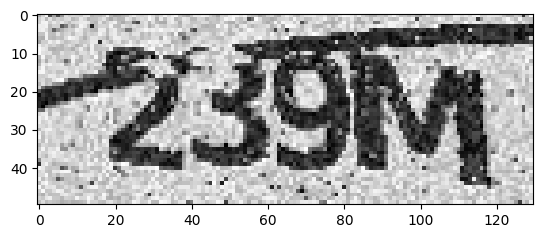

In [23]:
import matplotlib.pyplot as plt
print(origin_X_tensor[0].shape)
tensor = origin_X_tensor[0].permute(2, 0, 1)
tensor = tensor.permute(1, 2, 0)
print(tensor.shape)
# if tensor.min() < 0 or tensor.max() > 1:
    # tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

plt.imshow(tensor)

# print(origin_Y_onehot_tensor[0])

In [49]:
# from torchvision import datasets, transforms

# transform = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize((0.5,), (0.5,))])
# train_loader = torch.utils.data.DataLoader(origin_X_tensor, batch_size=256, shuffle=True)
# test_loader = torch.utils.data.DataLoader(origin_Y_onehot_tensor, batch_size=256, shuffle=True)


In [26]:
origin_X_tensor_permuted = origin_X_tensor.permute(0, 3, 1, 2)


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCharCNN(nn.Module):
    def __init__(self):
        super(SimpleCharCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Assuming grayscale images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(24576, 512)  # Adjust the size according to your image size
        self.fc2 = nn.Linear(512, 76)  # 4 characters, each 26 possible letters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [40]:
# Split your data into training and validation sets
# For demonstration, let's assume origin_X_tensor and origin_Y_onehot_tensor are available
# and split manually for simplicity. Consider using `torch.utils.data.Dataset` and `DataLoader` for better handling.
from tqdm import tqdm
num_train = int(0.8 * len(origin_X_tensor))  # 80% for training
train_X = origin_X_tensor_permuted
train_Y = origin_Y_onehot_tensor.reshape(2500,-1)
print(train_Y.shape)
val_X = origin_X_tensor[num_train:]
val_Y = origin_Y_onehot_tensor[num_train:]

# Initialize the model, criterion, and optimizer
model = SimpleCharCNN()
criterion = nn.BCEWithLogitsLoss()  # Suitable for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    output = model(train_X)
    loss = criterion(output, train_Y)
    loss.backward()
    optimizer.step()
    print(train_Y.reshape(2500, 4, -1)[0])
    print(output.reshape(2500, 4, -1)[0])
    # Validation
    # model.eval()
    # with torch.no_grad():
    #     val_output = model(val_X)
    #     val_loss = criterion(val_output, val_Y)
    
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: ")


torch.Size([2500, 76])


 10%|█         | 1/10 [00:09<01:21,  9.02s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[ 0.0099, -0.0881, -0.0607,  0.0250, -0.0140, -0.0618, -0.0254,  0.0498,
          0.0320,  0.0391,  0.0180, -0.0144,  0.0096, -0.0481, -0.0020,  0.0269,
         -0.0673,  0.0303,  0.0589],
        [ 0.0014,  0.0603,  0.0410, -0.0960, -0.0172,  0.0226, -0.0698,  0.0563,
         -0.0006, -0.0190,  0.0508, -0.0022, -0.0187,  0.0365,  0.0418,  0.0499,
          0.0152, -0.0171,  0.0388],
        [-0.0110,  0.0332,  0.0221,  0.1109,  0.0058,  0.0280,  0.0551,  0.0010,
          0.0428,  0.0101, -0.0516, -0.0217, -0.0463,  0.0553,  0.0307, -0.0404,
         -0.1053,  0.0348, -0.0596],
        [ 0.0279, -0.0

 20%|██        | 2/10 [00:17<01:09,  8.73s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-4.7692, -4.6888, -2.2989, -0.3953, -1.4256, -1.9215, -2.1624, -1.9115,
         -0.6076, -1.3336, -2.7223, -3.5639, -2.3976, -2.6544, -0.9100, -1.9054,
         -1.8816, -2.6544, -0.0337],
        [-3.5408, -2.3447,  0.0070, -3.1055, -2.1194, -2.1010, -1.9620, -2.8019,
         -2.6445, -2.3176, -2.1901, -1.4707,  0.1255, -0.7319, -2.8295, -1.7648,
         -1.7926, -1.4834,  0.4218],
        [-2.1155, -0.9138, -0.5452, -0.1679, -1.0392, -2.8222, -2.6157, -2.5781,
         -0.8158, -2.7234, -1.2755, -0.9890, -4.0825, -2.4850, -0.7782, -2.1491,
         -2.8648, -3.1697, -3.1591],
        [-2.6153, -3.2

 30%|███       | 3/10 [00:26<01:02,  8.89s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-10.1097,  -8.5935,  -6.6800,  -4.3659,  -6.4850,  -5.7932,  -7.5974,
          -6.7885,  -5.2743,  -6.2620,  -4.9084,  -5.2576,  -6.1751,  -6.7690,
          -5.9960,  -4.5956,  -7.7105,  -6.2424,  -4.4710],
        [ -7.9477,  -6.9250,  -4.3441,  -7.1352,  -5.4828,  -5.5693,  -4.5302,
          -4.4340,  -7.7172,  -6.9676,  -6.8176,  -5.8774,  -3.9186,  -5.1294,
          -6.3529,  -6.0367,  -7.1209,  -5.0707,  -3.1355],
        [ -5.6015,  -4.4204,  -2.4923,  -5.6197,  -4.5038,  -6.2654,  -6.4100,
          -7.6144,  -5.7765,  -6.6619,  -4.6314,  -5.9613,  -8.1921,  -6.8861,
          -4.9529,  -5.56

 40%|████      | 4/10 [00:35<00:53,  8.94s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-7.5878, -5.3465, -5.2600, -4.9788, -6.1092, -4.4239, -6.2887, -6.0122,
         -5.8544, -6.2597, -2.5362, -3.0626, -4.6661, -5.0578, -5.7839, -3.3165,
         -5.8731, -3.6578, -5.5262],
        [-5.8719, -5.9291, -5.8907, -5.0411, -3.9740, -4.0099, -2.7954, -1.6841,
         -5.8363, -5.8404, -5.2269, -5.4209, -4.4760, -5.8350, -4.0750, -4.9272,
         -5.8001, -3.9503, -4.3325],
        [-3.4471, -5.1323, -3.6206, -6.1952, -4.1781, -4.3380, -4.3808, -5.8097,
         -5.6528, -4.2893, -3.1416, -6.1458, -6.1000, -5.6957, -5.3613, -4.0469,
         -2.7436, -2.9400, -3.5833],
        [-2.6012, -3.1

 50%|█████     | 5/10 [00:44<00:44,  8.98s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-4.3179, -2.6334, -3.1622, -3.8601, -4.0191, -2.6853, -3.8650, -3.9502,
         -4.5239, -4.5957, -1.2174, -1.8029, -2.7614, -2.7102, -4.1556, -2.0937,
         -3.7033, -1.3996, -4.4351],
        [-3.3367, -3.9487, -4.9690, -2.7357, -2.3022, -2.4039, -1.9969, -1.7242,
         -3.3643, -3.5736, -3.1427, -3.6847, -3.8752, -4.7607, -1.8837, -3.0455,
         -3.6411, -2.3400, -3.6546],
        [-1.7102, -4.0523, -3.1493, -4.8768, -2.8779, -2.5640, -2.3788, -3.4920,
         -3.9049, -2.0728, -1.8400, -4.4751, -3.7211, -3.8122, -4.2164, -2.4779,
         -1.1715, -1.4498, -1.7331],
        [-1.7257, -1.8

 60%|██████    | 6/10 [00:53<00:35,  8.95s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-2.3467, -1.6355, -1.6994, -2.8792, -2.3459, -1.5579, -2.3467, -2.5332,
         -3.2998, -2.9366, -1.3359, -1.7983, -1.9048, -1.5543, -3.0120, -1.6341,
         -2.4716, -1.2380, -3.3057],
        [-1.9664, -2.4536, -3.6283, -1.5184, -1.7123, -1.5455, -1.8760, -1.9897,
         -1.5884, -2.1238, -1.9037, -2.3756, -3.0838, -3.6514, -1.3545, -1.7246,
         -2.2542, -1.5105, -2.8756],
        [-1.4629, -2.9721, -2.4306, -3.6188, -2.0226, -1.5928, -1.3973, -1.9443,
         -2.5241, -1.5017, -1.5720, -3.0549, -2.3015, -2.4190, -3.0322, -1.8623,
         -1.1651, -1.4888, -1.1839],
        [-1.6358, -1.6

 70%|███████   | 7/10 [01:02<00:27,  9.02s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-1.8235, -1.9659, -1.5012, -2.7395, -1.9379, -1.6128, -1.9825, -2.2556,
         -3.1008, -2.3668, -1.9698, -2.5058, -2.0385, -1.7502, -2.9993, -1.8478,
         -2.1160, -1.7052, -3.1257],
        [-1.8413, -2.0541, -3.4057, -1.4971, -2.0050, -1.6871, -2.1336, -2.6901,
         -1.1390, -2.0203, -1.7535, -2.2211, -3.1248, -3.4965, -1.7076, -1.6027,
         -1.8078, -1.6601, -2.9412],
        [-1.8763, -2.7545, -2.5232, -3.5175, -2.0999, -1.6782, -1.5096, -1.6452,
         -2.2880, -2.0224, -1.9662, -2.7767, -2.0559, -2.0598, -2.8125, -2.0717,
         -1.7613, -2.1150, -1.5305],
        [-2.1854, -2.0

 80%|████████  | 8/10 [01:11<00:17,  8.98s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-2.0483, -2.8674, -1.9413, -3.3828, -2.1292, -2.2913, -2.3211, -2.6413,
         -3.4760, -2.4155, -3.0878, -3.7575, -2.6739, -2.4855, -3.4654, -2.7370,
         -2.3074, -2.7263, -3.5338],
        [-2.2479, -2.2354, -3.7966, -2.1399, -2.7173, -2.2795, -2.8517, -3.8337,
         -1.4380, -2.5653, -2.1620, -2.5832, -3.6361, -3.8429, -2.5754, -2.1370,
         -2.0703, -2.3494, -3.4834],
        [-2.7610, -3.1323, -3.1248, -4.0226, -2.7301, -2.1340, -2.0297, -2.0155,
         -2.6241, -3.0586, -3.0170, -3.2688, -2.3229, -2.4343, -3.1122, -2.8810,
         -2.6595, -3.0733, -2.3308],
        [-3.1378, -2.9

 90%|█████████ | 9/10 [01:20<00:09,  9.08s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-2.5533, -3.7978, -2.7593, -4.0605, -2.6237, -3.2073, -2.7844, -3.1093,
         -3.8300, -2.5474, -4.2462, -5.0371, -3.3770, -3.4465, -3.9401, -3.6837,
         -2.4920, -3.7679, -4.0364],
        [-2.8150, -2.6700, -4.2880, -3.1112, -3.4958, -3.1428, -3.5682, -4.9522,
         -2.1405, -3.2721, -2.7752, -3.1331, -4.1768, -4.1762, -3.4974, -2.9130,
         -2.5111, -3.2016, -4.0639],
        [-3.7997, -3.4668, -3.7589, -4.5292, -3.4448, -2.8641, -2.8315, -2.6754,
         -3.1219, -4.2471, -4.0802, -3.7923, -2.7186, -3.0148, -3.4998, -3.6889,
         -3.6498, -4.1250, -3.4229],
        [-4.1727, -3.8

100%|██████████| 10/10 [01:29<00:00,  8.99s/it]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.]])
tensor([[-2.8988, -4.2361, -3.3958, -4.2948, -2.9682, -3.8083, -3.0209, -3.2831,
         -3.7746, -2.6056, -4.8318, -5.6605, -3.6885, -4.0004, -3.9674, -4.1438,
         -2.5130, -4.2864, -4.1410],
        [-3.1368, -2.9753, -4.3824, -3.8572, -3.8573, -3.7659, -3.8353, -5.4857,
         -2.8669, -3.6750, -3.1486, -3.3994, -4.2805, -4.0429, -3.9945, -3.4825,
         -2.8239, -3.6853, -4.1946],
        [-4.3468, -3.4633, -3.9743, -4.5865, -3.7495, -3.3603, -3.4235, -3.1442,
         -3.3181, -4.9301, -4.6421, -3.9225, -2.9603, -3.4073, -3.5642, -3.9576,
         -4.2354, -4.6792, -4.1977],
        [-4.6225, -4.3

In [31]:

def load_data_torch(data_path):
    # Load the MATLAB file
    data = scipy.io.loadmat(data_path)
    print(data.keys())
    # print(data['y'].shape)
    # print(data['x'][0])
    origin_X = np.array(data['x'].flat)  # Example for uniform shape. Adjust based on actual data structure
    origin_Y = np.array(data['y'][0].reshape(5000, -1))
    origin_Y_onehot = np.array(data['y_onehot'].reshape(5000, 4, 19))
    print(origin_Y_onehot[0])

    

    print ("x_train shape: "+str(x_train.shape))
    print ("x_test shape: "+str(x_test.shape))

    y_train_onehot=origin_Y_onehot[0:num_train_data]
    y_test_onehot=origin_Y_onehot[num_train_data:]

    print ("y_train_onehot shape: "+str(y_train_onehot.shape))
    print ("y_test_onehot shape: "+str(y_test_onehot.shape))
    # Convert to PyTorch tensors
    origin_X_tensor = torch.tensor(origin_X, dtype=torch.float32)
    origin_Y_tensor = torch.tensor(origin_Y, dtype=torch.float32)
    origin_Y_onehot_tensor = torch.tensor(origin_Y_onehot, dtype=torch.float32)
    
    print("origin_X_tensor shape: "+str(origin_X_tensor.shape))
    print("origin_Y_tensor shape: "+str(origin_Y_tensor.shape))
    print("origin_Y_onehot_tensor shape: "+str(origin_Y_onehot_tensor.shape))

    return origin_X_tensor, origin_Y_tensor, origin_Y_onehot_tensor
    # return 0, 0, 0
origin_X, origin_Y, origin_Y_onehot = load_data_torch(path)


dict_keys(['__header__', '__version__', '__globals__', 'y_onehot', 'x', 'y'])
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [23]:
import torch
from torchvision import datasets, transforms

def load_original_data_pytorch(path):
    # Define a transform to normalize the data
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    
    # Download and load the training data
    trainset = datasets.MNIST(path, download=True, train=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

    # Download and load the test data
    testset = datasets.MNIST(path, download=True, train=False, transform=transform)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

    return train_loader, test_loader
path = 'D:\\Casper\\OTHER\\Data\\MNIST_data'
train_loader, test_loader = load_original_data_pytorch(path)
loaders = {
    'train': train_loader,
    'test': test_loader
}


In [10]:
def pprint(output = '\n', show_time = False): # print and fprint at the same time
    filename = "hw2-1.txt"
    print(output)
    with open(filename, 'a') as f:
        if show_time:
            f.write(datetime.now().strftime("[%Y-%m-%d %H:%M:%S] "))

        f.write(str(output))
        f.write('\n')
pprint("build function", True)

build function


In [11]:
def count_parameters(model):
    total_num = 0

    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num


In [27]:
import time
import torchvision.models as models
from torch import nn, optim
from tqdm import tqdm
def train(model, model_name):
    pprint(f"test {model_name}", True)
    model_parameters_amount = count_parameters(model)
    pprint(f"model total parameters: {model_parameters_amount:,}")

    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    lr= 0.005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    pprint(f"learning rate={lr}")
    iteration = 0
    epochs = 20
    start = time.time()
    phases = ['train', 'test']
    for epoch in range(epochs):
        for phase in phases:
            running_loss = 0.0
            correct_predictions = 0
            correct_top3_predictions = 0
            total_samples = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            for images, labels in tqdm(loaders[phase]): # Iterate over data.
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train': # backward + optimize only if in training phase
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()

                # Convert outputs to predicted class by selecting the class with the highest score
                _, predicted = torch.max(outputs, 1)
                # Accumulate the number of correct predictions
                correct_predictions += (predicted == labels).sum().item()
                
                _, top3_preds = outputs.topk(3, 1, True, True)
                correct_top3_predictions += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

                total_samples += labels.size(0)
                iteration += 1
                # if iteration % 20 == 0:
                #     print(iteration)
            avg_loss = running_loss / total_samples
            top1_accuracy = correct_predictions / total_samples * 100
            top3_accuracy = correct_top3_predictions / total_samples * 100
            pprint(f"Epoch [{epoch+1}/{epochs}], phase: {phase}, samples: {total_samples}, Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%")
    end = time.time()
    duration = end - start
    pprint(f"Elapsed time: {duration} seconds")
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(f'{model_name}.pt') # Save
    pprint(f"weight saved as: {model_name}.pt")   


In [25]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # First layer: 784 input features, 128 output features
        self.fc2 = nn.Linear(128, 64)   # Second layer: 128 input features, 64 output features
        self.fc3 = nn.Linear(64, 10)    # Final layer: 64 input features, 10 output features (digits 0-9)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input tensor
        x = F.relu(self.fc1(x))  # Apply ReLU non-linearity after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU non-linearity after second layer
        x = self.fc3(x)  # No non-linearity after final layer
        return F.log_softmax(x, dim=1)  # Apply log-softmax to output for classification


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 64)  # The image size is reduced to 7x7 after pooling layers
        self.fc2 = nn.Linear(64, 10)  # 10 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution -> ReLU -> Pooling
        x = torch.flatten(x, 1)  # Flatten
        x = F.relu(self.fc1(x))  # Dense layer -> ReLU
        x = self.fc2(x)  # Output layer
        return F.log_softmax(x, dim=1)  # Log Softmax activation for the output


In [28]:
model_list = [
    SimpleNN(),
    SimpleCNN(),
]

model_name = [
    "SimpleNN",
    "SimpleCNN",
]
for ii in range(len(model_name)):
    train(model_list[ii], model_name[ii])

test SimpleNN
model total parameters: 109,386
learning rate=0.005


100%|██████████| 235/235 [00:12<00:00, 18.31it/s]


Epoch [1/20], phase: train, samples: 60000, Loss: 0.0017, Top-1 Accuracy: 86.47%, Top-3 Accuracy: 96.00%


100%|██████████| 40/40 [00:02<00:00, 19.57it/s]


Epoch [1/20], phase: test, samples: 10000, Loss: 0.0009, Top-1 Accuracy: 93.02%, Top-3 Accuracy: 99.05%


100%|██████████| 235/235 [00:12<00:00, 18.45it/s]


Epoch [2/20], phase: train, samples: 60000, Loss: 0.0007, Top-1 Accuracy: 94.18%, Top-3 Accuracy: 99.11%


100%|██████████| 40/40 [00:01<00:00, 21.86it/s]


Epoch [2/20], phase: test, samples: 10000, Loss: 0.0006, Top-1 Accuracy: 95.15%, Top-3 Accuracy: 99.45%


100%|██████████| 235/235 [00:12<00:00, 19.09it/s]


Epoch [3/20], phase: train, samples: 60000, Loss: 0.0006, Top-1 Accuracy: 95.53%, Top-3 Accuracy: 99.45%


100%|██████████| 40/40 [00:01<00:00, 20.42it/s]


Epoch [3/20], phase: test, samples: 10000, Loss: 0.0005, Top-1 Accuracy: 96.24%, Top-3 Accuracy: 99.53%


100%|██████████| 235/235 [00:12<00:00, 18.25it/s]


Epoch [4/20], phase: train, samples: 60000, Loss: 0.0005, Top-1 Accuracy: 96.42%, Top-3 Accuracy: 99.63%


100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Epoch [4/20], phase: test, samples: 10000, Loss: 0.0006, Top-1 Accuracy: 95.94%, Top-3 Accuracy: 99.44%


100%|██████████| 235/235 [00:12<00:00, 18.10it/s]


Epoch [5/20], phase: train, samples: 60000, Loss: 0.0004, Top-1 Accuracy: 96.60%, Top-3 Accuracy: 99.62%


100%|██████████| 40/40 [00:02<00:00, 19.94it/s]


Epoch [5/20], phase: test, samples: 10000, Loss: 0.0006, Top-1 Accuracy: 95.55%, Top-3 Accuracy: 99.31%


100%|██████████| 235/235 [00:13<00:00, 17.93it/s]


Epoch [6/20], phase: train, samples: 60000, Loss: 0.0004, Top-1 Accuracy: 97.05%, Top-3 Accuracy: 99.72%


100%|██████████| 40/40 [00:01<00:00, 21.86it/s]


Epoch [6/20], phase: test, samples: 10000, Loss: 0.0004, Top-1 Accuracy: 96.72%, Top-3 Accuracy: 99.58%


 70%|███████   | 165/235 [00:09<00:04, 17.37it/s]


KeyboardInterrupt: 